In [1]:
from caveclient import CAVEclient
import os

def save_skeleton_as_swc(client, segment_id, save_path):
    """
    Download a skeleton as a SWC DataFrame and save to .swc file.
    """
    print(f"⏳ Downloading skeleton for segment {segment_id}...")
    swc_df = client.skeleton.get_skeleton(segment_id, output_format='swc')

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    swc_df.to_csv(save_path, sep=' ', index=False, header=False)
    print(f"✅ Saved SWC to {save_path}")

client = CAVEclient("minnie65_public")
client.version = 1300  # this is important!

segment_id = 864691135572530981  # pyramidal cell from the tutorial
save_path = "../data/864691135572530981.swc"

save_skeleton_as_swc(client, segment_id, save_path)


⏳ Downloading skeleton for segment 864691135572530981...
✅ Saved SWC to ../data/864691135572530981.swc


In [10]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import KDTree
import time

def compute_synaptic_embeddings(
    client,
    segment_id,
    skel_path,
    k=20,
    synapse_table_name='synapse',
    output_csv_path=None,
):
    start = time.time()
    print(f"⏳ Starting embedding for segment {segment_id}")

    # === Step 1: Load the SWC ===
    swc_file = f"{skel_path}/{segment_id}.swc"
    df = pd.read_csv(
        swc_file,
        delim_whitespace=True,
        comment='#',
        names=["id", "type", "x", "y", "z", "radius", "parent"]
    )
    print(f"📂 Loaded SWC file: {swc_file} ({len(df)} nodes)")
    t1 = time.time()

    # === Step 2: Build graph from SWC ===
    G = nx.Graph()
    node_positions = {}

    for _, row in df.iterrows():
        node_id = int(row["id"])
        parent_id = int(row["parent"])
        coord = np.array([row["x"], row["y"], row["z"]])
        node_positions[node_id] = coord
        G.add_node(node_id)
        if parent_id != -1:
            parent_coord = node_positions[parent_id]
            dist = np.linalg.norm(coord - parent_coord)
            G.add_edge(parent_id, node_id, weight=dist)

    t2 = time.time()
    print(f"🧠 Graph built in {t2 - t1:.2f} sec with {len(G.nodes)} nodes and {len(G.edges)} edges")

    # === Step 3: Compute Laplacian eigenmodes ===
    L = nx.laplacian_matrix(G, weight='weight')
    eigenvalues, eigenvectors = eigsh(L, k=k, which='SM', tol=1e-3)
    t3 = time.time()
    print(f"🎵 Computed {k} eigenmodes in {t3 - t2:.2f} sec")

    # === Step 4: Query synapse locations ===
    print(f"🔎 Querying synapses from table '{synapse_table_name}' for segment {segment_id}...")
    query_start = time.time()
    synapse_df = client.materialize.synapse_query(post_ids=[segment_id])
    query_end = time.time()
    print(f"📥 Queried {len(synapse_df)} synapses in {query_end - query_start:.2f} sec")

    if synapse_df.empty:
        print(f"⚠️ No synapses found for neuron {segment_id}.")
        return pd.DataFrame()

    # === Step 5: Map synapses to nearest skeleton nodes ===
    skeleton_coords = np.array(list(node_positions.values()))
    node_ids = list(node_positions.keys())
    tree = KDTree(skeleton_coords)

    pos = np.vstack(synapse_df["post_pt_position"].values)
    synapse_df["x"] = pos[:, 0]
    synapse_df["y"] = pos[:, 1]
    synapse_df["z"] = pos[:, 2]

    synapse_coords = synapse_df[["x", "y", "z"]].values
    distances, indices = tree.query(synapse_coords, k=1)
    nearest_nodes = [node_ids[idx[0]] for idx in indices]

    # === Step 6: Compute modal fingerprint for each synapse ===
    embeddings = []
    for node_id in nearest_nodes:
        node_index = list(G.nodes).index(node_id)
        embedding = eigenvectors[node_index] / eigenvalues
        embeddings.append(embedding)

    embedding_df = pd.DataFrame(embeddings, columns=[f"mode_{i+1}" for i in range(k)])
    embedding_df["synapse_id"] = synapse_df["id"].values

    if output_csv_path:
        embedding_df.to_csv(output_csv_path, index=False)
        print(f"✅ Saved embedding to {output_csv_path}")

    end = time.time()
    print(f"⏱️ Total embedding time: {end - start:.2f} sec")

    return embedding_df

df = compute_synaptic_embeddings(
    client,
    segment_id=864691135572530981,
    skel_path="../data",
    k=20,
    synapse_table_name='synapse',
    output_csv_path="synaptic_embedding.csv"
)


⏳ Starting embedding for segment 864691135572530981
📂 Loaded SWC file: ../data/864691135572530981.swc (7445 nodes)
🧠 Graph built in 0.46 sec with 7445 nodes and 7444 edges
🎵 Computed 20 eigenmodes in 85.35 sec
🔎 Querying synapses from table 'synapse' for segment 864691135572530981...
📥 Queried 7135 synapses in 15.80 sec
✅ Saved embedding to synaptic_embedding.csv
⏱️ Total embedding time: 102.40 sec


/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


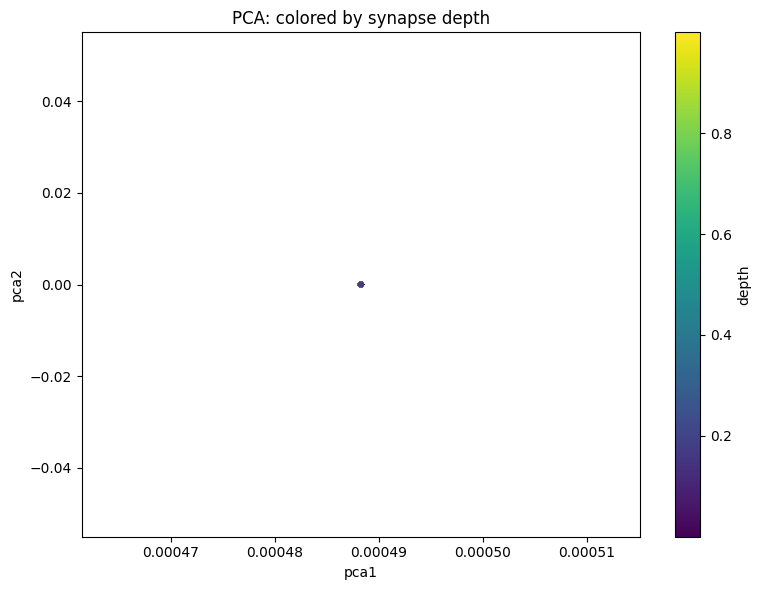

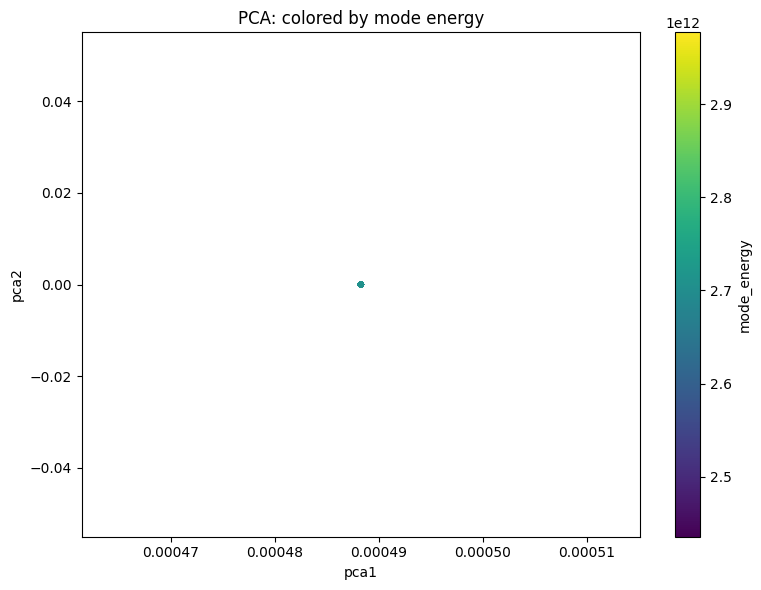

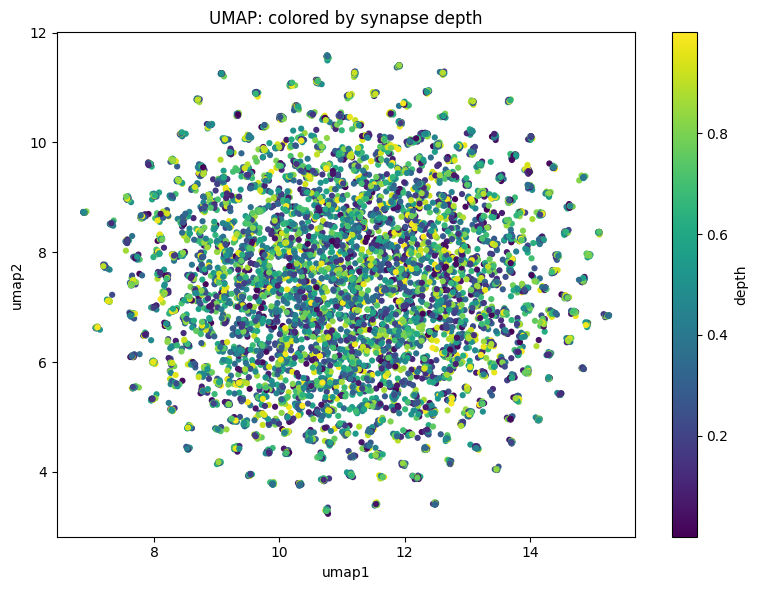

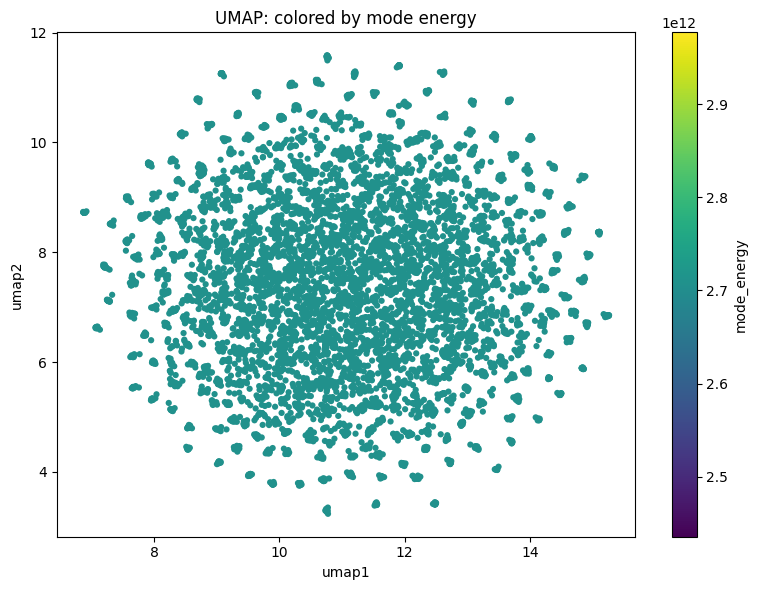

ModuleNotFoundError: No module named 'ace_tools'

In [11]:
# Re-run after state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
import seaborn as sns

# Load the saved embedding CSV
embedding_df = pd.read_csv("synaptic_embedding.csv")

# Extract just the mode columns
mode_columns = [col for col in embedding_df.columns if col.startswith("mode_")]
X = embedding_df[mode_columns].values

# Compute depth (assumes z is in microns; invert if needed)
if 'z' in embedding_df.columns:
    embedding_df["depth"] = embedding_df["z"]
else:
    embedding_df["depth"] = np.random.rand(len(embedding_df))  # fallback dummy

# Compute total modal energy per synapse (L2 norm of embedding)
embedding_df["mode_energy"] = np.linalg.norm(X, axis=1)

# --- PCA projection
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(X)
embedding_df["pca1"] = pca_proj[:, 0]
embedding_df["pca2"] = pca_proj[:, 1]

# --- UMAP projection
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
embedding_df["umap1"] = umap_proj[:, 0]
embedding_df["umap2"] = umap_proj[:, 1]

# Plotting function
def plot_embedding(df, x, y, color, title):
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(df[x], df[y], c=df[color], cmap="viridis", s=20, edgecolor='none')
    plt.colorbar(sc, label=color)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_embedding(embedding_df, "pca1", "pca2", "depth", "PCA: colored by synapse depth")
plot_embedding(embedding_df, "pca1", "pca2", "mode_energy", "PCA: colored by mode energy")
plot_embedding(embedding_df, "umap1", "umap2", "depth", "UMAP: colored by synapse depth")
plot_embedding(embedding_df, "umap1", "umap2", "mode_energy", "UMAP: colored by mode energy")

import ace_tools as tools; tools.display_dataframe_to_user(name="Synaptic Embedding DataFrame", dataframe=embedding_df)


In [21]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import KDTree
import time

def compute_synaptic_embeddings_patched(
    client,
    segment_id,
    skel_path,
    k=20,
    output_csv_path=None,
):
    start = time.time()
    print(f"⏳ Starting embedding for segment {segment_id}")

    # Step 1: Load SWC
    swc_file = f"{skel_path}/{segment_id}.swc"
    df = pd.read_csv(
        swc_file,
        delim_whitespace=True,
        comment='#',
        names=["id", "type", "x", "y", "z", "radius", "parent"]
    )
    print(f"📂 Loaded SWC file: {swc_file} ({len(df)} nodes)")
    t1 = time.time()

    # Step 2: Build graph
    G = nx.Graph()
    node_positions = {}

    for _, row in df.iterrows():
        node_id = int(row["id"])
        parent_id = int(row["parent"])
        coord = np.array([row["x"], row["y"], row["z"]])
        node_positions[node_id] = coord
        G.add_node(node_id)
        if parent_id != -1:
            parent_coord = node_positions[parent_id]
            dist = np.linalg.norm(coord - parent_coord)
            G.add_edge(parent_id, node_id, weight=dist)

    node_ids = list(G.nodes)
    node_id_to_index = {nid: i for i, nid in enumerate(node_ids)}
    skeleton_coords = np.array([node_positions[nid] for nid in node_ids])
    print('skeleton 0: ', skeleton_coords)
    #VOXEL_RES = np.array([4, 4, 40]) / 1000  # → microns

    # Apply scaling to node positions
    #skeleton_coords = np.array([node_positions[nid] * VOXEL_RES for nid in node_ids])
    #print('skeleton 1: ', skeleton_coords)
    t2 = time.time()
    print(f"🧠 Graph built in {t2 - t1:.2f} sec with {len(G.nodes)} nodes and {len(G.edges)} edges")

    # Step 3: Eigenmodes
    L = nx.laplacian_matrix(G, weight='weight')
    eigenvalues, eigenvectors = eigsh(L, k=k, which='SM',tol=1e-3)
    t3 = time.time()
    print(f"🎵 Computed {k} eigenmodes in {t3 - t2:.2f} sec")

    # Step 4: Synapse query
    print(f"🔎 Querying synapses...")
    synapse_df = client.materialize.synapse_query(post_ids=[segment_id])
    print(synapse_df.columns)#
    print(synapse_df['post_pt_position'].values)
    voxel_to_micron = np.array([4, 4, 40]) / 1000
    synapse_coords_voxel = np.vstack(synapse_df["post_pt_position"].values)
    synapse_coords_micron = synapse_coords_voxel * voxel_to_micron

    # Add to DataFrame for downstream use
    synapse_df["x"] = synapse_coords_micron[:, 0]
    synapse_df["y"] = synapse_coords_micron[:, 1]
    synapse_df["z"] = synapse_coords_micron[:, 2]
    #pos = np.vstack(synapse_df["post_pt_position"].values)
    #synapse_df["x"] = pos[:, 0]
    #synapse_df["y"] = pos[:, 1]
    #synapse_df["z"] = pos[:, 2]
    print(f"📥 Retrieved {len(synapse_df)} synapses")
    #print('Synapses: ', synapse_df)
    # Step 5: KDTree mapping
    tree = KDTree(skeleton_coords)
    synapse_coords = synapse_df[["x", "y", "z"]].values
    print('Synapses: ', synapse_coords)
    distances, indices = tree.query(synapse_coords, k=1)
    nearest_nodes = [node_ids[idx[0]] for idx in indices]
    print('Nearest nodes: ', nearest_nodes)

    print("🧾 Unique nearest skeleton nodes assigned:", len(set(nearest_nodes)))

    # Step 6: Embedding computation
    embeddings = []
    for node_id in nearest_nodes:
        node_index = node_id_to_index[node_id]
        embedding = eigenvectors[node_index] / eigenvalues
        embeddings.append(embedding)

    embedding_df = pd.DataFrame(embeddings, columns=[f"mode_{i+1}" for i in range(k)])
    embedding_df["synapse_id"] = synapse_df["id"].values
    embedding_df["x"] = synapse_df["x"].values
    embedding_df["y"] = synapse_df["y"].values
    embedding_df["z"] = synapse_df["z"].values

    if output_csv_path:
        embedding_df.to_csv(output_csv_path, index=False)
        print(f"✅ Saved to {output_csv_path}")

    print(f"⏱️ Done in {time.time() - start:.2f} sec")
    return embedding_df

df = compute_synaptic_embeddings_patched(
    client,
    segment_id=864691135572530981,
    skel_path="../data",
    k=20,
    output_csv_path="synaptic_embedding_fixed.csv"
)


⏳ Starting embedding for segment 864691135572530981
📂 Loaded SWC file: ../data/864691135572530981.swc (7445 nodes)
skeleton 0:  [[1365.12   763.456  812.6  ]
 [1368.2    755.76   811.24 ]
 [1368.2    758.552  811.68 ]
 ...
 [1362.048  760.6    814.   ]
 [1367.768  761.352  807.52 ]
 [1365.16   761.696  807.88 ]]
🧠 Graph built in 0.75 sec with 7445 nodes and 7444 edges
🎵 Computed 20 eigenmodes in 114.75 sec
🔎 Querying synapses...
Index(['id', 'created', 'superceded_id', 'valid', 'size',
       'pre_pt_supervoxel_id', 'pre_pt_root_id', 'post_pt_supervoxel_id',
       'post_pt_root_id', 'pre_pt_position', 'post_pt_position',
       'ctr_pt_position'],
      dtype='object')
[array([352700, 182240,  21263]) array([358872, 184530,  19853])
 array([330508, 186140,  20186]) ... array([356234, 183550,  21560])
 array([334380, 158204,  18106]) array([359094, 193142,  19868])]
📥 Retrieved 7135 synapses
Synapses:  [[1410.8    728.96   850.52 ]
 [1435.488  738.12   794.12 ]
 [1322.032  744.56   807

/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


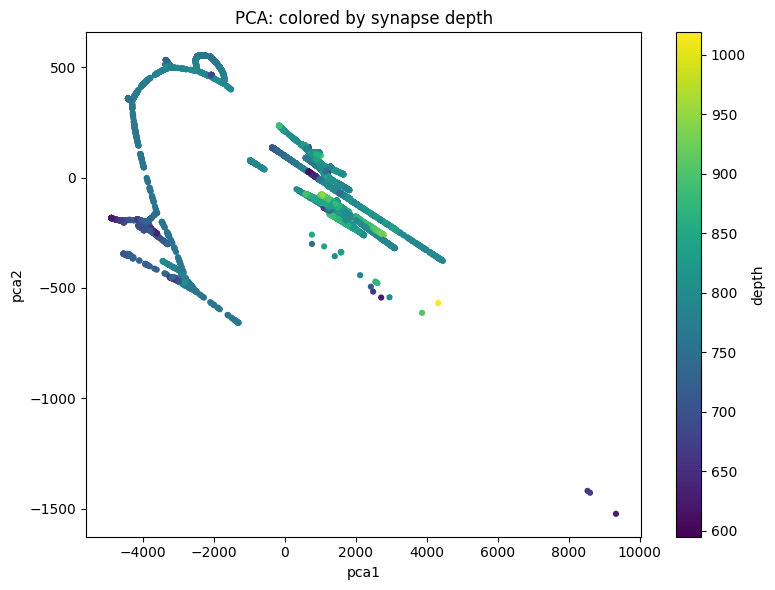

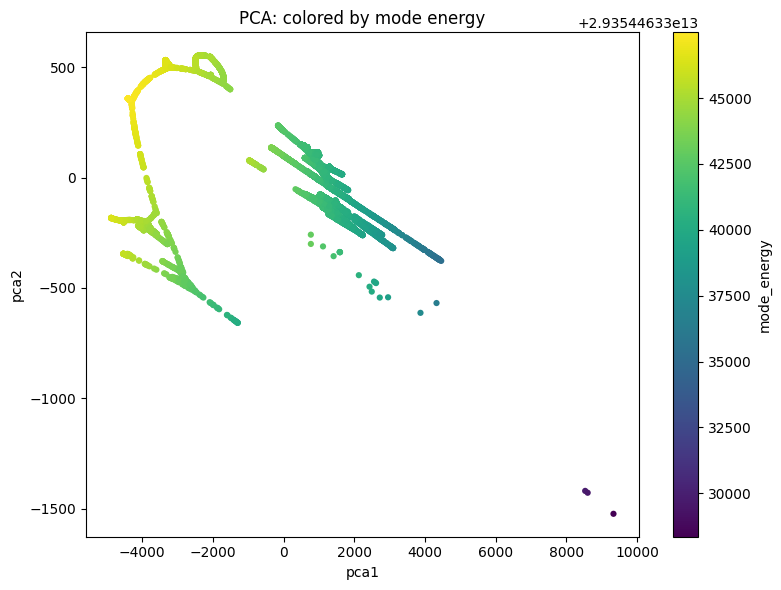

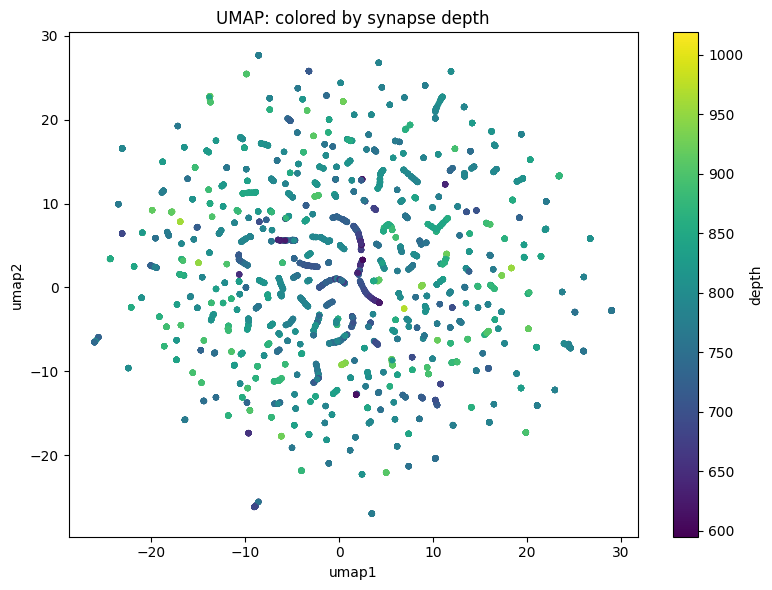

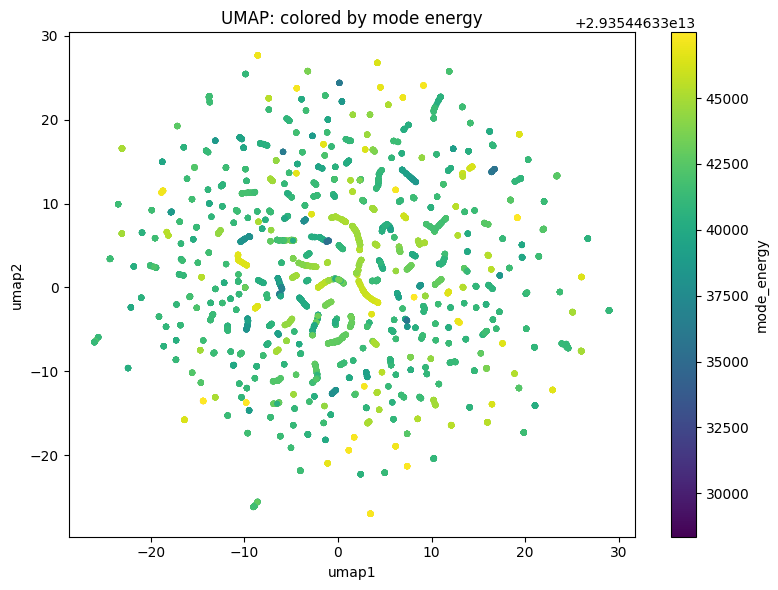

In [23]:
# Re-run after state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
import seaborn as sns

# Load the saved embedding CSV
embedding_df = pd.read_csv("synaptic_embedding_fixed.csv")

# Extract just the mode columns
mode_columns = [col for col in embedding_df.columns if col.startswith("mode_")]
X = embedding_df[mode_columns].values

# Compute depth (assumes z is in microns; invert if needed)
if 'z' in embedding_df.columns:
    embedding_df["depth"] = embedding_df["z"]
else:
    embedding_df["depth"] = np.random.rand(len(embedding_df))  # fallback dummy

# Compute total modal energy per synapse (L2 norm of embedding)
embedding_df["mode_energy"] = np.linalg.norm(X, axis=1)

# --- PCA projection
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(X)
embedding_df["pca1"] = pca_proj[:, 0]
embedding_df["pca2"] = pca_proj[:, 1]

# --- UMAP projection
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
embedding_df["umap1"] = umap_proj[:, 0]
embedding_df["umap2"] = umap_proj[:, 1]

# Plotting function
def plot_embedding(df, x, y, color, title):
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(df[x], df[y], c=df[color], cmap="viridis", s=20, edgecolor='none')
    plt.colorbar(sc, label=color)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_embedding(embedding_df, "pca1", "pca2", "depth", "PCA: colored by synapse depth")
plot_embedding(embedding_df, "pca1", "pca2", "mode_energy", "PCA: colored by mode energy")
plot_embedding(embedding_df, "umap1", "umap2", "depth", "UMAP: colored by synapse depth")
plot_embedding(embedding_df, "umap1", "umap2", "mode_energy", "UMAP: colored by mode energy")

#import ace_tools as tools; tools.display_dataframe_to_user(name="Synaptic Embedding DataFrame", dataframe=embedding_df)


In [24]:
# Re-import dependencies after code environment reset
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import KDTree
import time

def compute_synaptic_embeddings_classical(
    client,
    segment_id,
    skel_path,
    k=20,
    output_csv_path=None,
):
    start = time.time()
    print(f"🧠 Computing CLASSICAL embeddings for segment {segment_id}")

    # Step 1: Load SWC
    swc_file = f"{skel_path}/{segment_id}.swc"
    df = pd.read_csv(
        swc_file,
        delim_whitespace=True,
        comment='#',
        names=["id", "type", "x", "y", "z", "radius", "parent"]
    )
    print(f"📂 Loaded SWC with {len(df)} nodes")

    # Step 2: Build graph
    G = nx.Graph()
    node_positions = {}

    for _, row in df.iterrows():
        node_id = int(row["id"])
        parent_id = int(row["parent"])
        coord = np.array([row["x"], row["y"], row["z"]])
        node_positions[node_id] = coord
        G.add_node(node_id)
        if parent_id != -1:
            parent_coord = node_positions[parent_id]
            dist = np.linalg.norm(coord - parent_coord)
            G.add_edge(parent_id, node_id, weight=dist)

    node_ids = list(G.nodes)
    node_id_to_index = {nid: i for i, nid in enumerate(node_ids)}
    skeleton_coords = np.array([node_positions[nid] for nid in node_ids])

    # Step 3: Classical Laplacian eigenmodes
    L = nx.laplacian_matrix(G, weight='weight')
    eigenvalues, eigenvectors = eigsh(L, k=k, which='SM')

    # Step 4: Query synapse data
    from caveclient import CAVEclient
    client = CAVEclient("minnie65_public")
    client.version = 1300
    synapse_df = client.materialize.synapse_query(post_ids=[segment_id])
    pos_voxel = np.vstack(synapse_df["post_pt_position"].values)
    voxel_to_micron = np.array([4, 4, 40]) / 1000
    pos_micron = pos_voxel * voxel_to_micron
    synapse_df["x"] = pos_micron[:, 0]
    synapse_df["y"] = pos_micron[:, 1]
    synapse_df["z"] = pos_micron[:, 2]

    # Step 5: KDTree to map synapses to nearest nodes
    tree = KDTree(skeleton_coords)
    synapse_coords = synapse_df[["x", "y", "z"]].values
    distances, indices = tree.query(synapse_coords, k=1)
    nearest_nodes = [node_ids[idx[0]] for idx in indices]

    print("✅ Unique nearest skeleton nodes:", len(set(nearest_nodes)))

    # Step 6: Embedding
    embeddings = []
    for node_id in nearest_nodes:
        node_index = node_id_to_index[node_id]
        embedding = eigenvectors[node_index]
        embeddings.append(embedding)

    embedding_df = pd.DataFrame(embeddings, columns=[f"mode_{i+1}" for i in range(k)])
    embedding_df["synapse_id"] = synapse_df["id"].values
    embedding_df["x"] = synapse_df["x"].values
    embedding_df["y"] = synapse_df["y"].values
    embedding_df["z"] = synapse_df["z"].values

    if output_csv_path:
        embedding_df.to_csv(output_csv_path, index=False)
        print(f"💾 Saved classical embedding to {output_csv_path}")

    print(f"⏱️ Finished in {time.time() - start:.2f} sec")
    return embedding_df

from caveclient import CAVEclient

client = CAVEclient("minnie65_public")
client.version = 1300
segment_id = 864691135572530981
skel_path = "../data"

df_classical = compute_synaptic_embeddings_classical(
    client,
    segment_id=segment_id,
    skel_path=skel_path,
    k=20,
    output_csv_path="synaptic_embedding_classical.csv"
)


🧠 Computing CLASSICAL embeddings for segment 864691135572530981
📂 Loaded SWC with 7445 nodes
✅ Unique nearest skeleton nodes: 2865
💾 Saved classical embedding to synaptic_embedding_classical.csv
⏱️ Finished in 211.57 sec


/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maria/Documents/Synoptic/.microns/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


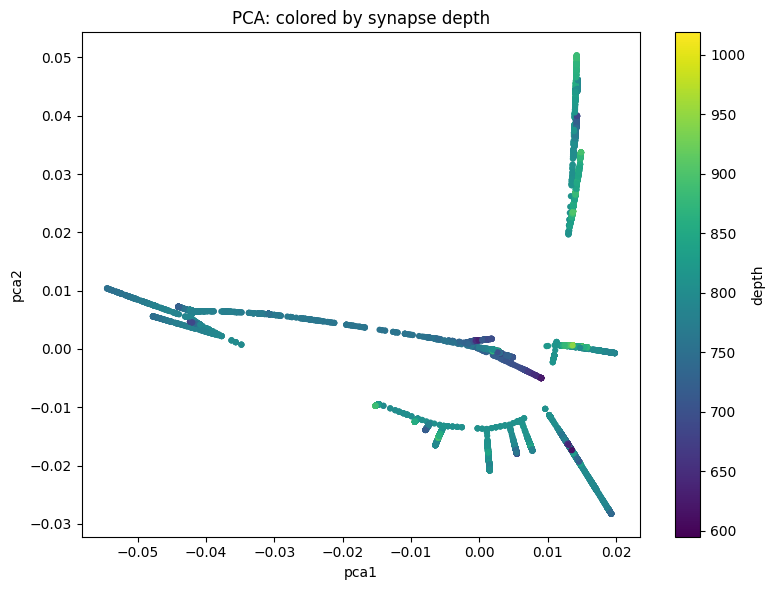

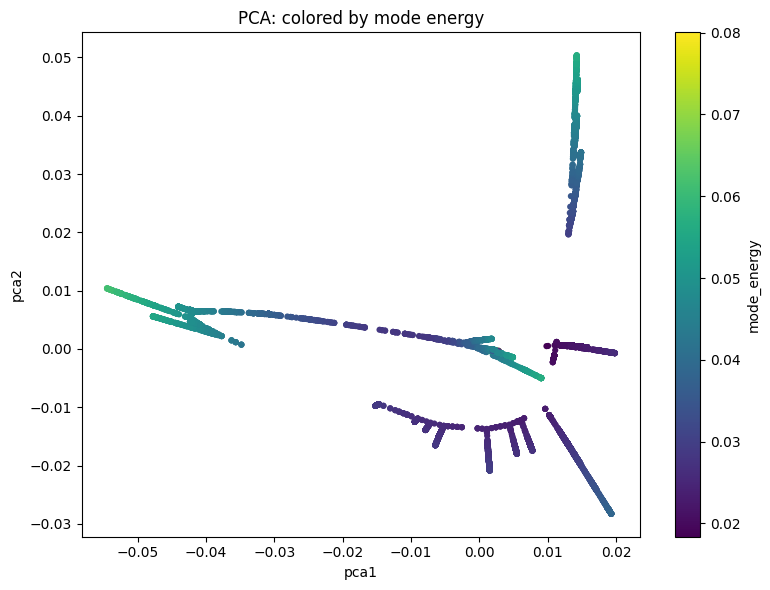

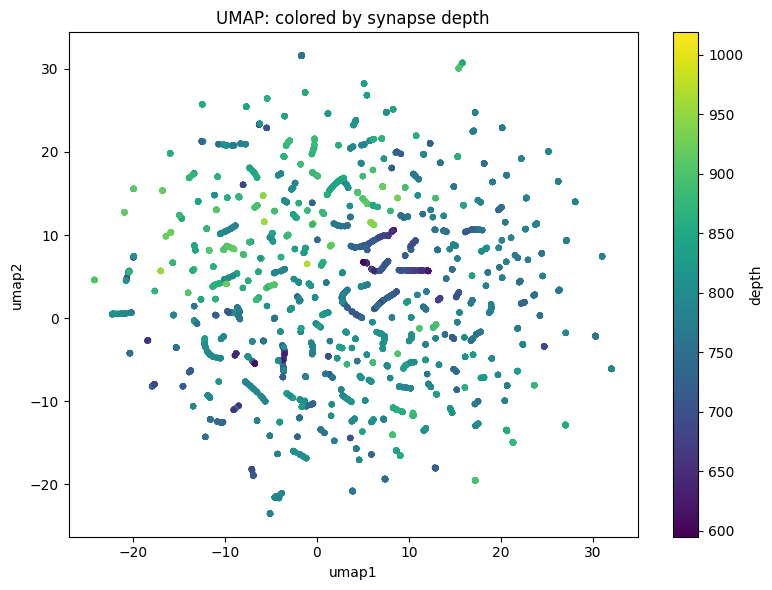

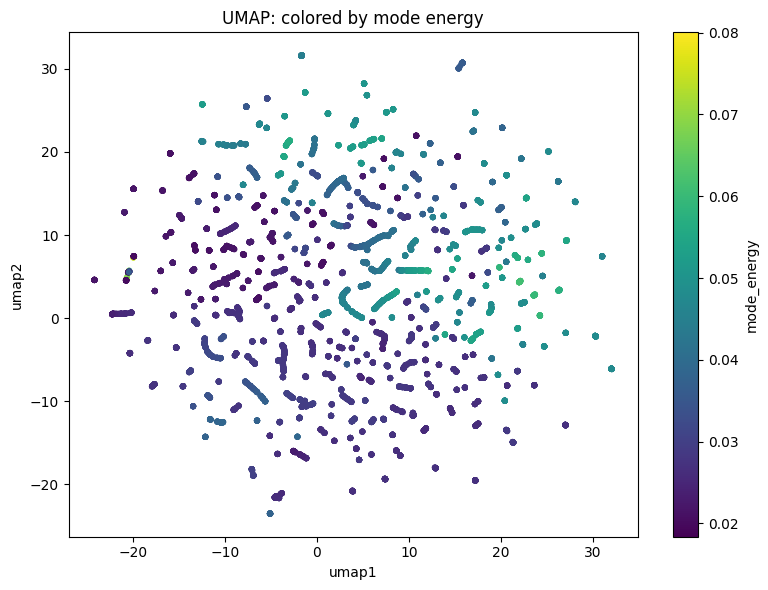

In [25]:
# Re-run after state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
import seaborn as sns

# Load the saved embedding CSV
embedding_df = pd.read_csv("synaptic_embedding_classical.csv")

# Extract just the mode columns
mode_columns = [col for col in embedding_df.columns if col.startswith("mode_")]
X = embedding_df[mode_columns].values

# Compute depth (assumes z is in microns; invert if needed)
if 'z' in embedding_df.columns:
    embedding_df["depth"] = embedding_df["z"]
else:
    embedding_df["depth"] = np.random.rand(len(embedding_df))  # fallback dummy

# Compute total modal energy per synapse (L2 norm of embedding)
embedding_df["mode_energy"] = np.linalg.norm(X, axis=1)

# --- PCA projection
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(X)
embedding_df["pca1"] = pca_proj[:, 0]
embedding_df["pca2"] = pca_proj[:, 1]

# --- UMAP projection
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
embedding_df["umap1"] = umap_proj[:, 0]
embedding_df["umap2"] = umap_proj[:, 1]

# Plotting function
def plot_embedding(df, x, y, color, title):
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(df[x], df[y], c=df[color], cmap="viridis", s=20, edgecolor='none')
    plt.colorbar(sc, label=color)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_embedding(embedding_df, "pca1", "pca2", "depth", "PCA: colored by synapse depth")
plot_embedding(embedding_df, "pca1", "pca2", "mode_energy", "PCA: colored by mode energy")
plot_embedding(embedding_df, "umap1", "umap2", "depth", "UMAP: colored by synapse depth")
plot_embedding(embedding_df, "umap1", "umap2", "mode_energy", "UMAP: colored by mode energy")